In [ ]:
pip install grad-cam

In [ ]:
!pip install torchcam

In [3]:
import pandas as pd
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import InterpolationMode
from torchvision import models
from torchvision import transforms
from PIL import Image
import random
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from torchcam.methods import SmoothGradCAMpp, GradCAM
from torchvision.transforms.functional import to_pil_image
import seaborn as sns
import cv2
from google.colab import drive
from torchvision.models import ResNet50_Weights # Import ResNet50_Weights
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
import copy
from collections import defaultdict

In [4]:
seed=42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
!kaggle datasets download -d xhlulu/140k-real-and-fake-faces

Dataset URL: https://www.kaggle.com/datasets/xhlulu/140k-real-and-fake-faces
License(s): other
100% 3.74G/3.75G [00:23<00:00, 164MB/s]
100% 3.75G/3.75G [00:24<00:00, 168MB/s]


In [ ]:
!unzip 140k-real-and-fake-faces.zip -d /content/

In [7]:
train_df = pd.read_csv('/content/train.csv', index_col=0)
test_df = pd.read_csv('/content/test.csv', index_col=0)
valid_df = pd.read_csv('/content/valid.csv', index_col=0)
print('Train Dataset Paths and Labels')
display(train_df.head())
print('Test Dataset Paths and Labels')
display(test_df.head())
print('Validation Dataset Paths and Labels')
display(valid_df.head())

Train Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,31355,1,real,train/real/31355.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,02884,1,real,train/real/02884.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,33988,1,real,train/real/33988.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,53875,1,real,train/real/53875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,24149,1,real,train/real/24149.jpg


Test Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,18233,1,real,test/real/18233.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,54317,1,real,test/real/54317.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,40155,1,real,test/real/40155.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,12875,1,real,test/real/12875.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,52543,1,real,test/real/52543.jpg


Validation Dataset Paths and Labels


,original_path,id,label,label_str,path
0,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,20001,1,real,valid/real/20001.jpg
1,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,11264,1,real,valid/real/11264.jpg
2,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,19817,1,real,valid/real/19817.jpg
3,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,46851,1,real,valid/real/46851.jpg
4,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,10411,1,real,valid/real/10411.jpg


In [8]:
# Base directory where images are stored
base_img_dir = '/content/real_vs_fake/real-vs-fake/'

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

## Apply Filters and Test Performance

This part implements a custom convolutional neural network (CNN) for image classification, with an emphasis on applying various image filters (Gaussian, Sobel, and Laplacian) to enhance feature extraction. The network includes convolutional layers, adaptive pooling, and fully connected layers for classification.

To evaluate the model's performance, the PerformanceTester class computes metrics like accuracy, loss, confusion matrix, ROC AUC, and inference times. It generates a detailed performance report and visualizations, including confusion matrices and ROC curves. The results are saved as images and CSV files for further analysis.

The pipeline is designed to work with a dataset loaded from a CSV file, where images are processed with standard transformations before being passed through the model. This approach provides a comprehensive evaluation of the model's accuracy and efficiency..

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class CustomFilter(nn.Module):
    """Custom filter layer that applies various image processing operations"""
    def __init__(self, in_channels):
        super(CustomFilter, self).__init__()

        # Learnable parameters for filter weights
        self.gaussian_weight = nn.Parameter(torch.randn(1))
        self.sobel_weight = nn.Parameter(torch.randn(1))
        self.laplacian_weight = nn.Parameter(torch.randn(1))

        # Define filter kernels
        self.register_buffer('gaussian', self._create_gaussian_kernel())
        self.register_buffer('sobel_x', self._create_sobel_kernel_x())
        self.register_buffer('sobel_y', self._create_sobel_kernel_y())
        self.register_buffer('laplacian', self._create_laplacian_kernel())

        # 1x1 convolution to adjust channel dimensions
        self.channel_adj = nn.Conv2d(in_channels * 4, in_channels, 1)

    def _create_gaussian_kernel(self, sigma=1.0):
        """Create 5x5 Gaussian kernel"""
        size = 5
        coords = torch.arange(size) - (size - 1) / 2
        x, y = torch.meshgrid(coords, coords)
        kernel = torch.exp(-(x**2 + y**2) / (2 * sigma**2))
        return (kernel / kernel.sum()).unsqueeze(0).unsqueeze(0)

    def _create_sobel_kernel_x(self):
        """Create Sobel X kernel"""
        kernel = torch.tensor([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]], dtype=torch.float32)
        return kernel.unsqueeze(0).unsqueeze(0)

    def _create_sobel_kernel_y(self):
        """Create Sobel Y kernel"""
        kernel = torch.tensor([[-1, -2, -1],
                             [0, 0, 0],
                             [1, 2, 1]], dtype=torch.float32)
        return kernel.unsqueeze(0).unsqueeze(0)

    def _create_laplacian_kernel(self):
        """Create Laplacian kernel"""
        kernel = torch.tensor([[0, 1, 0],
                             [1, -4, 1],
                             [0, 1, 0]], dtype=torch.float32)
        return kernel.unsqueeze(0).unsqueeze(0)

    def forward(self, x):
        batch_size, channels, height, width = x.shape
        filtered_outputs = []

        # Process each channel separately
        for c in range(channels):
            channel = x[:, c:c+1]

            # Apply Gaussian filter
            gaussian_out = F.conv2d(channel, self.gaussian, padding=2)
            gaussian_out = self.gaussian_weight * gaussian_out

            # Apply Sobel filters
            sobel_x_out = F.conv2d(channel, self.sobel_x, padding=1)
            sobel_y_out = F.conv2d(channel, self.sobel_y, padding=1)
            sobel_magnitude = self.sobel_weight * torch.sqrt(sobel_x_out**2 + sobel_y_out**2)

            # Apply Laplacian filter
            laplacian_out = self.laplacian_weight * F.conv2d(channel, self.laplacian, padding=1)

            # Concatenate original and filtered outputs
            filtered = torch.cat([channel, gaussian_out, sobel_magnitude, laplacian_out], dim=1)
            filtered_outputs.append(filtered)

        # Combine all channels
        output = torch.cat(filtered_outputs, dim=1)

        # Adjust channel dimensions
        return self.channel_adj(output)

class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()

        # Initial convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        # Custom filter layer
        self.filter_layer = CustomFilter(32)

        # Deep feature extraction blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )

        # Adaptive pooling for variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Classification layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Initial convolution
        x = self.conv1(x)

        # Apply custom filters
        x = self.filter_layer(x)

        # Deep feature extraction
        x = self.features(x)

        # Adaptive pooling
        x = self.adaptive_pool(x)

        # Classification
        x = self.classifier(x)

        return x

def test_model():
    # Create sample input
    batch_size = 4
    channels = 3
    height = 64
    width = 64
    x = torch.randn(batch_size, channels, height, width)

    # Initialize model
    model = CustomCNN(num_classes=2)

    # Forward pass
    output = model(x)

    print(f"Input shape: {x.shape}")
    print(f"Output shape: {output.shape}")
    print("\nModel summary:")
    print(model)

if __name__ == "__main__":
    test_model()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Input shape: torch.Size([4, 3, 64, 64])
Output shape: torch.Size([4, 2])

Model summary:
CustomCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (filter_layer): CustomFilter(
    (channel_adj): Conv2d(128, 32, kernel_size=(1, 1), stride=(1, 1))
  )
  (features): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

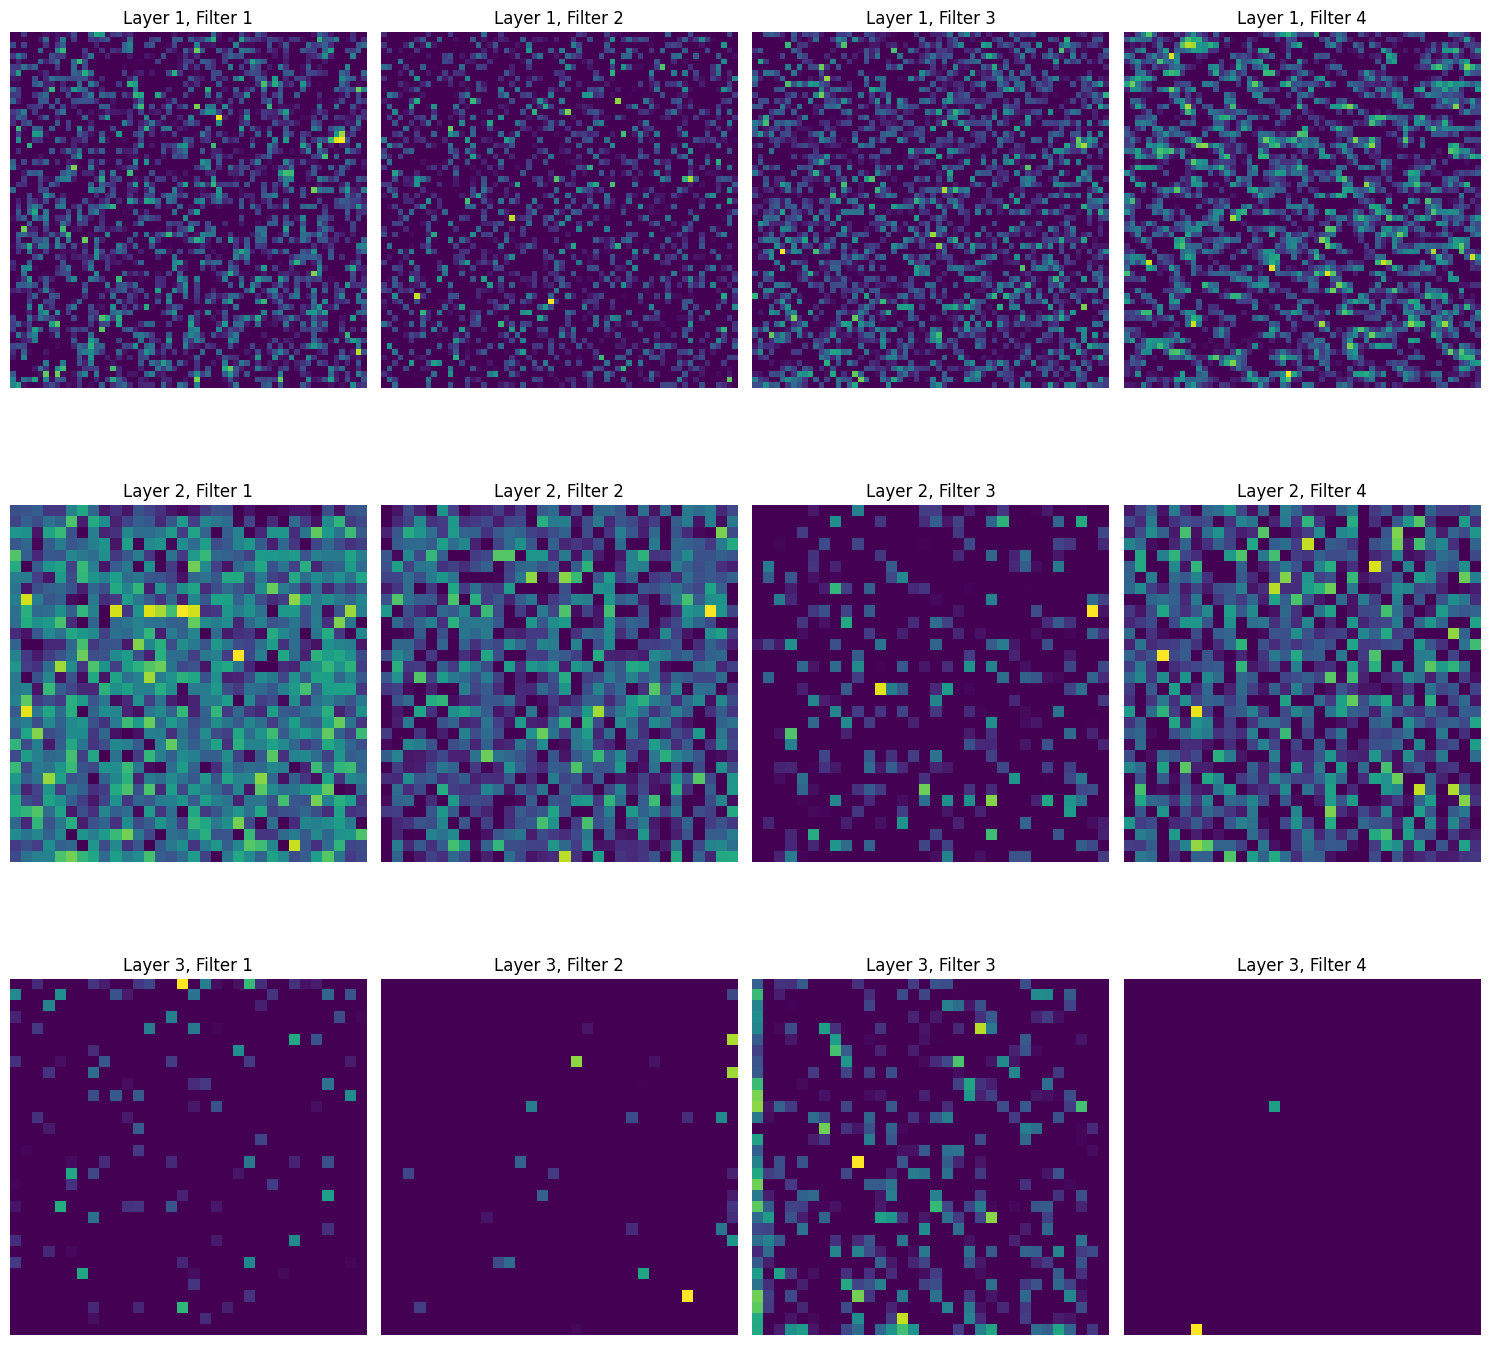


Performance Metrics:
avg_activation:
  Layer 1: 0.2297
  Layer 2: 0.1270
  Layer 3: 0.0385
sparsity:
  Layer 1: 50.9735
  Layer 2: 42.8772
  Layer 3: 56.9519
variance:
  Layer 1: 0.1187
  Layer 2: 0.0281
  Layer 3: 0.0043


In [12]:
class CNNFilterTester(nn.Module):
    def __init__(self, in_channels, filter_configs):
        """
        Initialize CNN Filter Tester

        Args:
            in_channels: Number of input channels
            filter_configs: List of filter configurations to test
                          Each config should contain:
                          {
                              'out_channels': int,
                              'kernel_size': int,
                              'stride': int,
                              'padding': int
                          }
        """
        super().__init__()
        self.filter_configs = filter_configs
        self.conv_layers = nn.ModuleList()

        for config in filter_configs:
            self.conv_layers.append(
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=config['out_channels'],
                    kernel_size=config['kernel_size'],
                    stride=config['stride'],
                    padding=config['padding']
                )
            )
            in_channels = config['out_channels']

    def forward(self, x):
        """
        Forward pass through all filter configurations
        Returns intermediate activations for analysis
        """
        activations = []
        for conv in self.conv_layers:
            x = F.relu(conv(x))
            activations.append(x)
        return activations

 #Test Filters Function
def test_filters(
    model: CNNFilterTester,
    test_image: torch.Tensor,
    save_path: str = None
) -> None:
    """
    Test and visualize filter outputs

    Args:
        model: Initialized CNNFilterTester
        test_image: Input image tensor (B, C, H, W)
        save_path: Optional path to save visualizations
    """
    model.eval()
    with torch.no_grad():
        activations = model(test_image)

    fig, axes = plt.subplots(len(activations), 4, figsize=(15, 5*len(activations)))
    if len(activations) == 1:
        axes = axes[np.newaxis, :]

    for i, activation in enumerate(activations):
        # Show first 4 channels of each layer's output
        for j in range(4):
            if j < activation.shape[1]:
                axes[i, j].imshow(activation[0, j].cpu().numpy(), cmap='viridis')
                axes[i, j].set_title(f'Layer {i+1}, Filter {j+1}')
                axes[i, j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

#Analyze Performance Function
def analyze_performance(activations):
    """
    Analyze filter performance metrics

    Returns:
        Dictionary containing:
        - Average activation values
        - Sparsity (% of zero activations)
        - Feature map variance
    """
    metrics = {
        'avg_activation': [],
        'sparsity': [],
        'variance': []
    }

    for activation in activations:
        metrics['avg_activation'].append(
            float(activation.mean().item())
        )
        metrics['sparsity'].append(
            float((activation == 0).float().mean().item() * 100)
        )
        metrics['variance'].append(
            float(activation.var().item())
        )

    return metrics

# Example usage
if __name__ == "__main__":
    # Define test configurations
    filter_configs = [
        {'out_channels': 16, 'kernel_size': 3, 'stride': 1, 'padding': 1},
        {'out_channels': 32, 'kernel_size': 3, 'stride': 2, 'padding': 1},
        {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1}
    ]

    # Create model and test image
    model = CNNFilterTester(in_channels=3, filter_configs=filter_configs)
    test_image = torch.randn(1, 3, 64, 64)  # Example input

    # Test filters and analyze performance
    test_filters(model, test_image, save_path='filter_visualization.png')
    activations = model(test_image)
    metrics = analyze_performance(activations)

    print("\nPerformance Metrics:")
    for metric, values in metrics.items():
        print(f"{metric}:")
        for i, value in enumerate(values):
            print(f"  Layer {i+1}: {value:.4f}")

In [14]:
class FaceDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        '''
        Args:
            dataframe (pd.DataFrame): DataFrame containing image paths and labels
            transform (callable, optional): Optional transform to be applied on a sample
        '''
        self.dataframe = dataframe  # Store the dataframe
        self.transform = transform  # Store the transform (if present)

    def __len__(self):
        return len(self.dataframe)  # Return the length of the dataframe

    def __getitem__(self, idx):
        # Get the image path and label from the dataframe
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)  # Label is 0 or 1 (fake or real)

        # Open the image using PIL
        image = Image.open(img_path)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        return image, label  # Return image and label


Testing model performance...


100%|██████████| 625/625 [00:45<00:00, 13.60it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Performance Report:
Accuracy: 50.00%
Average Inference Time: 13.50 ms
ROC AUC: 0.4910

Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67     10000
           1       0.00      0.00      0.00     10000

    accuracy                           0.50     20000
   macro avg       0.25      0.50      0.33     20000
weighted avg       0.25      0.50      0.33     20000



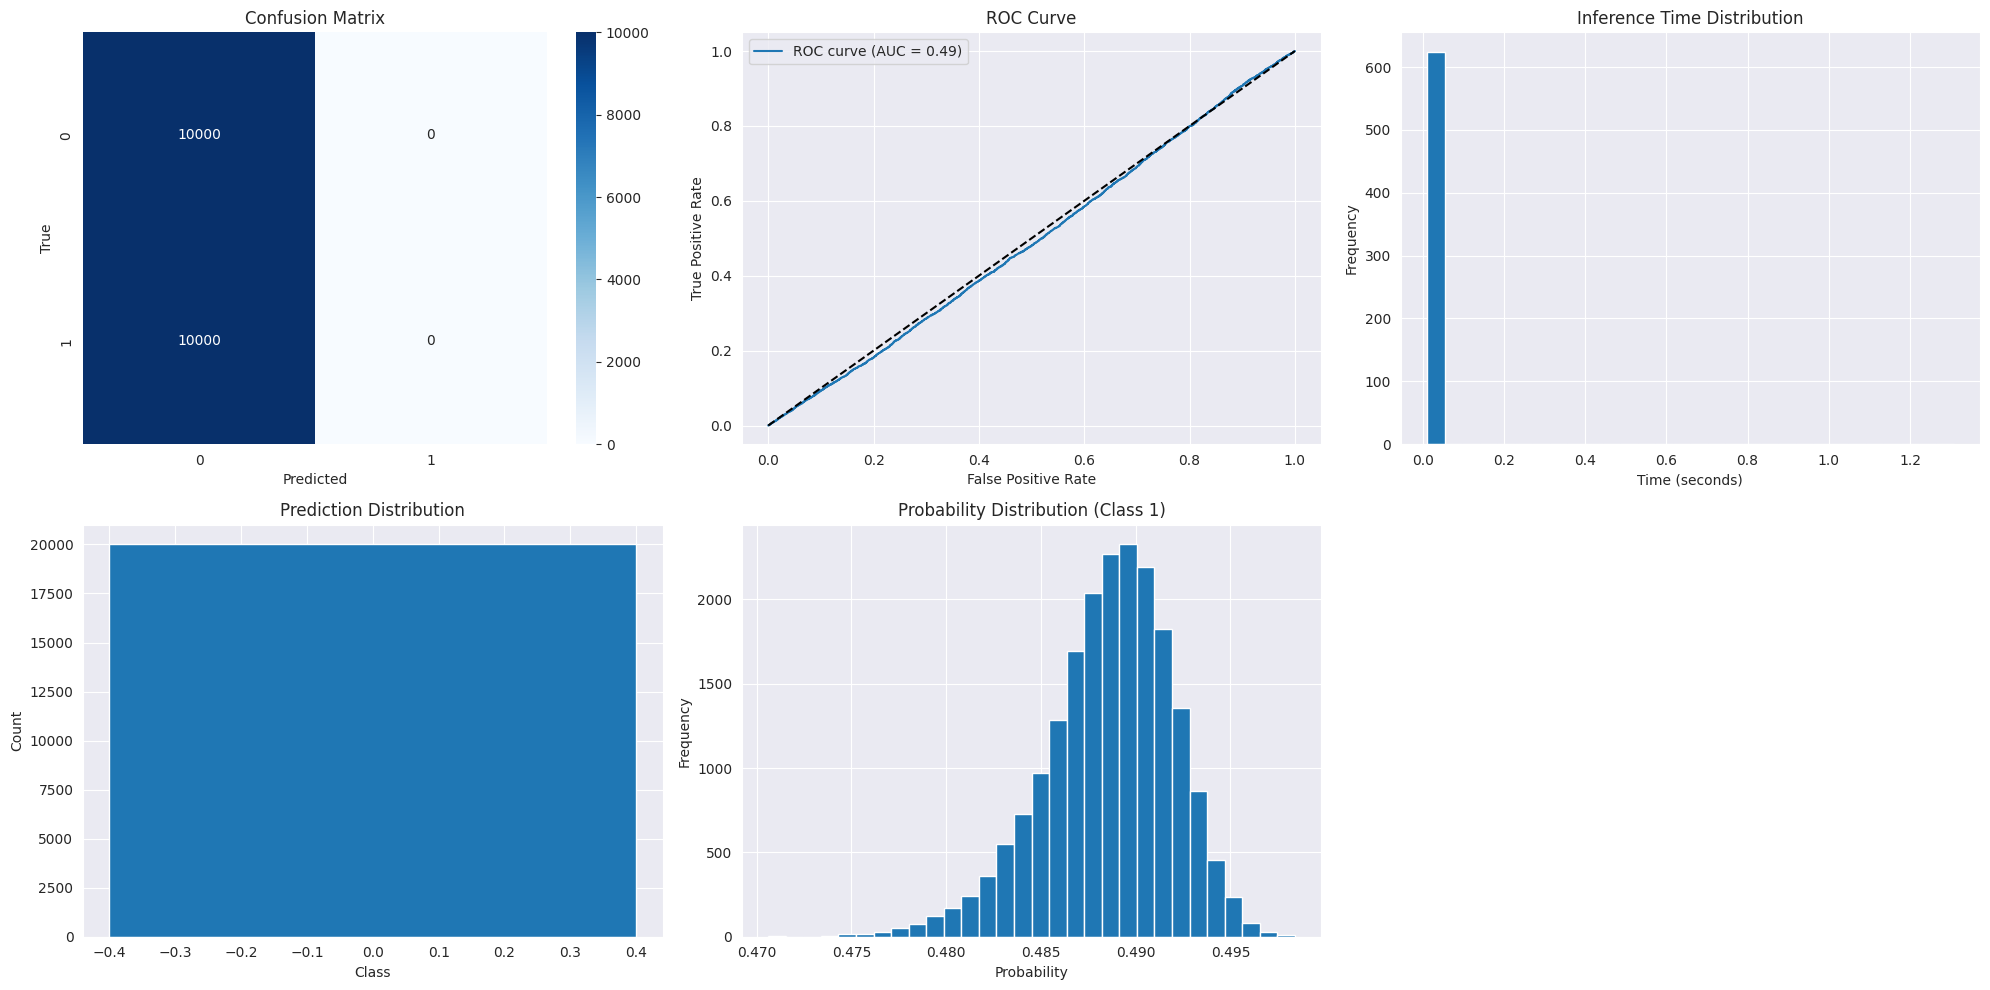


Results saved to 'results' directory


In [15]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
from pathlib import Path
import pandas as pd
import os

class PerformanceTester:
    def __init__(self, model, device='cuda'):
        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.model.eval()

        # Initialize metrics storage
        self.metrics = {
            'accuracy': [],
            'loss': [],
            'predictions': [],
            'true_labels': [],
            'probabilities': [],
            'inference_times': []
        }

    def test_performance(self, test_loader, criterion):
        """Evaluate model performance on test set"""
        print("\nTesting model performance...")

        total_correct = 0
        total_samples = 0
        total_loss = 0

        with torch.no_grad():
            for images, labels in tqdm(test_loader):
                images = images.to(self.device)
                labels = labels.to(self.device)

                # Measure inference time
                start_time = time.time()
                outputs = self.model(images)
                inference_time = time.time() - start_time

                # Calculate loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                # Get predictions
                _, predicted = torch.max(outputs.data, 1)
                total_samples += labels.size(0)
                total_correct += (predicted == labels).sum().item()

                # Store metrics
                self.metrics['predictions'].extend(predicted.cpu().numpy())
                self.metrics['true_labels'].extend(labels.cpu().numpy())
                self.metrics['probabilities'].extend(torch.softmax(outputs, dim=1).cpu().numpy())
                self.metrics['inference_times'].append(inference_time)

        # Calculate final metrics
        accuracy = 100 * total_correct / total_samples
        avg_loss = total_loss / len(test_loader)

        self.metrics['accuracy'] = accuracy
        self.metrics['loss'] = avg_loss

        return self.metrics

    def generate_performance_report(self):
        """Generate comprehensive performance report"""
        predictions = np.array(self.metrics['predictions'])
        true_labels = np.array(self.metrics['true_labels'])
        probabilities = np.array(self.metrics['probabilities'])

        # Calculate confusion matrix
        cm = confusion_matrix(true_labels, predictions)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(true_labels, probabilities[:, 1])
        roc_auc = auc(fpr, tpr)

        # Calculate inference statistics
        inference_times = np.array(self.metrics['inference_times'])

        report = {
            'Classification Report': classification_report(true_labels, predictions),
            'Confusion Matrix': cm,
            'ROC AUC': roc_auc,
            'Average Inference Time': np.mean(inference_times),
            'Inference Time Std': np.std(inference_times),
            'Accuracy': self.metrics['accuracy'],
            'Loss': self.metrics['loss']
        }

        return report

    def visualize_results(self, report):
        """Create visualizations for performance metrics"""
        # Set up the plotting style
        sns.set_style('darkgrid')

        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(20, 10))

        # 1. Confusion Matrix
        plt.subplot(2, 3, 1)
        sns.heatmap(report['Confusion Matrix'], annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')

        # 2. ROC Curve
        plt.subplot(2, 3, 2)
        fpr, tpr, _ = roc_curve(self.metrics['true_labels'],
                               np.array(self.metrics['probabilities'])[:, 1])
        plt.plot(fpr, tpr, label=f'ROC curve (AUC = {report["ROC AUC"]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend()

        # 3. Inference Time Distribution
        plt.subplot(2, 3, 3)
        plt.hist(self.metrics['inference_times'], bins=30)
        plt.title('Inference Time Distribution')
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')

        # 4. Prediction Distribution
        plt.subplot(2, 3, 4)
        pred_dist = pd.Series(self.metrics['predictions']).value_counts()
        plt.bar(pred_dist.index, pred_dist.values)
        plt.title('Prediction Distribution')
        plt.xlabel('Class')
        plt.ylabel('Count')

        # 5. Probability Distribution
        plt.subplot(2, 3, 5)
        plt.hist(np.array(self.metrics['probabilities'])[:, 1], bins=30)
        plt.title('Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Frequency')

        plt.tight_layout()
        return fig

def main():
    # Initialize model and data
    model = CustomCNN()  # Your model
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

   # Load the test data:
    test_df = pd.read_csv('/content/test.csv', index_col=0)

    # Base directory where images are stored
    base_img_dir = '/content/real_vs_fake/real-vs-fake/'

    # Combine the base path with the relative paths from the 'path' column
    test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))

    # Create the test dataset with the DataFrame
    test_dataset = FaceDataset(test_df, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


    # Initialize performance tester
    tester = PerformanceTester(model)
    criterion = nn.CrossEntropyLoss()

    # Test performance
    metrics = tester.test_performance(test_loader, criterion)

    # Generate and print report
    report = tester.generate_performance_report()

    print("\nPerformance Report:")
    print(f"Accuracy: {report['Accuracy']:.2f}%")
    print(f"Average Inference Time: {report['Average Inference Time']*1000:.2f} ms")
    print(f"ROC AUC: {report['ROC AUC']:.4f}")
    print("\nClassification Report:")
    print(report['Classification Report'])

    # Create visualizations
    fig = tester.visualize_results(report)
    plt.show()

    # Save results
    results_path = Path('results')
    results_path.mkdir(exist_ok=True)

    # Save metrics to CSV
    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Loss', 'ROC AUC', 'Avg Inference Time'],
        'Value': [report['Accuracy'], report['Loss'],
                 report['ROC AUC'], report['Average Inference Time']]
    })
    metrics_df.to_csv(results_path / 'metrics.csv', index=False)

    # Save figures
    fig.savefig(results_path / 'performance_visualization.png')

    print("\nResults saved to 'results' directory")

if __name__ == "__main__":
    main()


Epoch 1/5


Evaluating: 100%|██████████| 313/313 [00:33<00:00,  9.25it/s]


Train Loss: 0.2273 Acc: 90.71%
Valid Loss: 0.1201 Acc: 95.24%

Epoch 2/5


Evaluating: 100%|██████████| 313/313 [00:33<00:00,  9.33it/s]


Train Loss: 0.1291 Acc: 94.91%
Valid Loss: 0.0936 Acc: 96.30%

Epoch 3/5


Evaluating: 100%|██████████| 313/313 [00:33<00:00,  9.21it/s]


Train Loss: 0.1019 Acc: 96.12%
Valid Loss: 0.0907 Acc: 96.56%

Epoch 4/5


Evaluating: 100%|██████████| 313/313 [00:33<00:00,  9.22it/s]


Train Loss: 0.0834 Acc: 96.88%
Valid Loss: 0.0679 Acc: 97.39%

Epoch 5/5


Evaluating: 100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


Train Loss: 0.0715 Acc: 97.28%
Valid Loss: 0.0951 Acc: 96.23%


Evaluating: 100%|██████████| 313/313 [00:33<00:00,  9.28it/s]


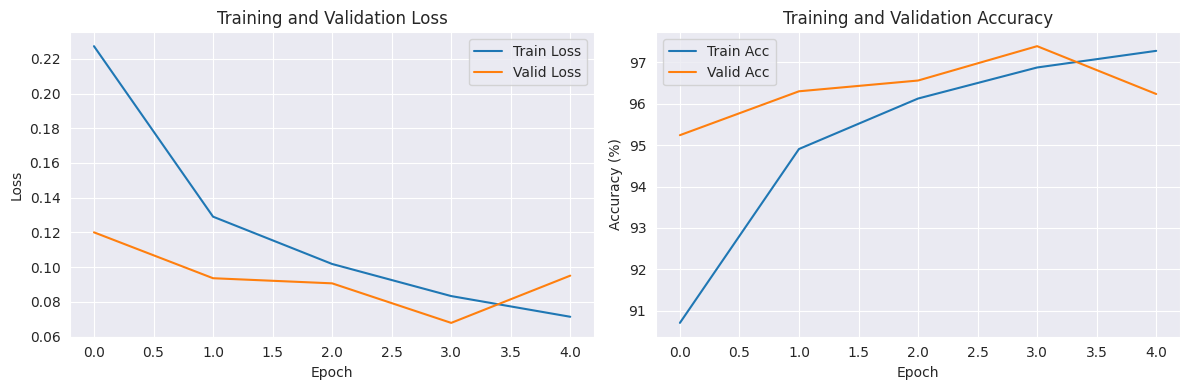

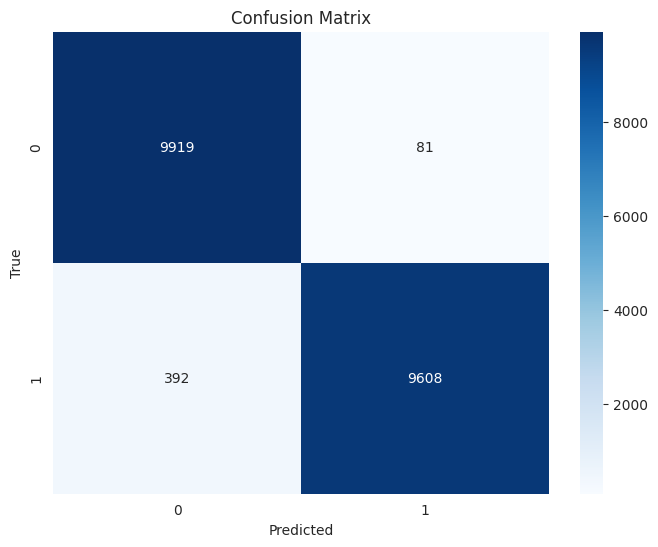


Test Set Metrics:
Accuracy: 97.64%
Precision: 0.9916
Recall: 0.9608
F1-Score: 0.9760


In [18]:
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score
import copy
from collections import defaultdict
from tqdm import tqdm
from torchvision import models
import os
# Load pretrained ResNet50
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Load the train data using pandas, for example:
train_df = pd.read_csv('/content/train.csv', index_col=0) # Adjust path as needed

# Base directory where images are stored
base_img_dir = '/content/real_vs_fake/real-vs-fake/'

# Load the validation data using pandas, similar to train_df
valid_df = pd.read_csv('/content/valid.csv', index_col=0)
# Load the test data using pandas
test_df = pd.read_csv('/content/test.csv', index_col=0)

# Combine the base path with the relative paths from the 'path' column
train_df['image_path'] = train_df['path'].apply(lambda x: os.path.join(base_img_dir, x))
valid_df['image_path'] = valid_df['path'].apply(lambda x: os.path.join(base_img_dir, x)) # Process valid_df similarly
test_df['image_path'] = test_df['path'].apply(lambda x: os.path.join(base_img_dir, x))


# Define stronger data augmentation for training
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Keep original validation/test transforms
eval_transform = transforms.Compose([
    transforms.Resize(232),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class AugmentedFaceDataset(Dataset):
    def __init__(self, dataframe, transform=None, augment_prob=0.5):
        self.dataframe = dataframe
        self.transform = transform
        self.augment_prob = augment_prob

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx].image_path
        label = int(self.dataframe.iloc[idx].label)

        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return image, label

def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc='Training'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating'):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    num_epochs=10
    # Calculate additional metrics
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return {
        'loss': epoch_loss,
        'accuracy': epoch_acc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_preds,
        'true_labels': all_labels
    }

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler,
                num_epochs, device, early_stopping_patience=3):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0
    history = defaultdict(list)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')

        # Train phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        valid_metrics = evaluate(model, valid_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_metrics['loss'])
        history['valid_acc'].append(valid_metrics['accuracy'])

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}%')
        print(f'Valid Loss: {valid_metrics["loss"]:.4f} Acc: {valid_metrics["accuracy"]:.2f}%')

        # Deep copy the model if best accuracy
        if valid_metrics['accuracy'] > best_acc:
            best_acc = valid_metrics['accuracy']
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered after epoch {epoch+1}')
            break

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Create datasets with augmentation
train_dataset_aug = AugmentedFaceDataset(train_df, transform=train_transform)
valid_dataset = AugmentedFaceDataset(valid_df, transform=eval_transform)
test_dataset = AugmentedFaceDataset(test_df, transform=eval_transform)

# Create data loaders
train_loader_aug = DataLoader(train_dataset_aug, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(resnet50.parameters(), lr=0.001, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet50 = resnet50.to(device)

# Train the model
model, history = train_model(
    resnet50,
    train_loader_aug,
    valid_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=5,
    device=device,
    early_stopping_patience=3
)

# Evaluate on test set
test_metrics = evaluate(model, test_loader, criterion, device)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['valid_loss'], label='Valid Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['valid_acc'], label='Valid Acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Plot confusion matrix
cm = confusion_matrix(test_metrics['true_labels'], test_metrics['predictions'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print("\nTest Set Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1-Score: {test_metrics['f1']:.4f}")